In [213]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [214]:
data = pd.read_csv (os.path.join ("Datasets", "Part-3_Bioactivity_Three_PubChem_PIC50.csv"))
data.head ()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,PIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.12
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.00
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.30
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.52
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.10


In [215]:
X = data.drop (columns = ['PIC50'])

In [223]:
Y = []
for i in range (len (data)) :
    if data.PIC50 [i] < 5 :
        Y.append ('inactive')
    elif data.PIC50 [i] > 6 :
        Y.append ('active')
    else :
        Y.append ('intermediate')
Y = pd.DataFrame (Y, columns = ['activity'])
Y.head ()

,activity
0,active
1,active
2,inactive
3,active
4,active


### Label Encode the features

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder ()
Y = label_encoder.fit_transform (Y)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder (sparse = False)
Y = Y.reshape (len (Y), 1)
Y_enc = onehot_encoder.fit_transform (Y)

print (X.head (3))
print (Y_enc)

print (X.shape)
print (Y_enc.shape)

   PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0           1           1           1           0           0           0   
1           1           1           1           0           0           0   
2           1           1           0           0           0           0   

   PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP871  \
0           0           0           0           1  ...             0   
1           0           0           0           1  ...             0   
2           0           0           0           1  ...             0   

   PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  PubchemFP876  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0             0             0            

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [15]:
def build_model (hp) :
    model = keras.Sequential ()
    model.add (layers.Dense (input_shape = (881, ), units = hp.Int ('units', min_value = 32, max_value = 512, step = 128), activation = 'relu'))
    
    for i in range (hp.Int ('layers', 2, 3)) :
        model.add (layers.Dense (units = hp.Int ('units_' + str (i), 32, 256, step = 32), activation = hp.Choice ('act_' + str (i), ['relu', 'sigmoid'])))
        
    model.add (layers.Dense (3, activation = 'sigmoid'))
    model.compile (optimizer = keras.optimizers.Adam
                   (hp.Choice ('learning_rate',
                               values = [1e-1, 1e-3])),
                   loss = 'mean_absolute_error',
                   metrics = ['accuracy'])
    return model

In [16]:
tuner = RandomSearch (build_model,
                      objective = 'accuracy',
                      max_trials = 10,
                      executions_per_trial = 1)

In [17]:
tuner.search (X_train, y_train,
             epochs = 100,
             validation_data = (X_test, y_test))

Trial 10 Complete [00h 00m 40s]
accuracy: 0.6313896775245667

Best accuracy So Far: 0.7839712500572205
Total elapsed time: 00h 08m 33s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.7527


In [21]:
best_model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               141120    
                                                                 
 dense_1 (Dense)             (None, 224)               36064     
                                                                 
 dense_2 (Dense)             (None, 224)               50400     
                                                                 
 dense_3 (Dense)             (None, 64)                14400     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 242,179
Trainable params: 242,179
Non-trainable params: 0
_________________________________________________________________


In [342]:
model = keras.Sequential ()
model.add (layers.Dense (input_shape = (881, ), units = 160, activation = 'relu'))

model.add (layers.Dense (units = 224, activation = 'relu'))    
model.add (layers.Dense (units = 224, activation = 'relu'))
model.add (layers.Dense (units = 64, activation = 'relu'))

model.add (layers.Dense (3, activation = 'softmax'))

learning_rate = 1e-3
model.compile (optimizer = tf.keras.optimizers.Adam (learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = False),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [343]:
fit_model = model.fit (X_train, y_train, epochs = 1000, verbose = 0)
print ("Done")

Done


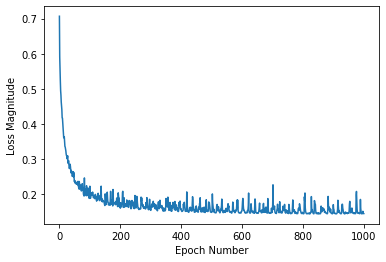

In [344]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel ('Epoch Number')
plt.ylabel ("Loss Magnitude")

plt.plot (fit_model.history ['loss'])

In [345]:
y_pred = model.predict (X_test)
y_pred

array([[9.9987316e-01, 1.2685613e-04, 6.3884542e-09],
       [1.0000000e+00, 9.5170183e-09, 1.4696974e-13],
       [7.4379081e-01, 4.1757594e-03, 2.5203347e-01],
       ...,
       [8.8867807e-01, 5.7271238e-02, 5.4050766e-02],
       [6.2368791e-20, 1.0000000e+00, 2.6663050e-38],
       [9.9591112e-01, 4.0888442e-03, 3.8318358e-14]], dtype=float32)

In [346]:
train_acc = model.evaluate (X_train, y_train, verbose = 0)
test_acc = model.evaluate (X_test, y_test, verbose = 0)
print ("Train Loss, Accuracy : ", train_acc)
print ("Test Loss, Accuracy : ", test_acc)

Train Loss, Accuracy :  [0.14166472852230072, 0.9291034936904907]
Test Loss, Accuracy :  [3.8111143112182617, 0.7613526582717896]


### Regularization
##### The model seems to be overfitting, so adding some regularization parameters

In [424]:
model = keras.Sequential ()
initializer = tf.keras.initializers.GlorotUniform ()

model.add (layers.Dense (input_shape = (881, ),
                         units = 160,
                         activation = 'relu',
                         kernel_initializer = initializer
                         ))
model.add (layers.Dense (units = 224,
                         activation = 'relu',
                         kernel_regularizer = tf.keras.regularizers.L2 (0.1),
                         kernel_initializer = initializer
                         ))    
model.add (layers.Dense (units = 224,
                         activation = 'relu',
                         kernel_regularizer = tf.keras.regularizers.L2 (0.1),
                         kernel_initializer = initializer
                         ))
model.add (layers.Dense (units = 64,
                         activation = 'relu',
                         kernel_regularizer = tf.keras.regularizers.L2 (0.1),
                         kernel_initializer = initializer
                         ))

model.add (layers.Dense (3, activation = 'softmax',
                         kernel_regularizer = tf.keras.regularizers.L2 (0.1),
                         ))

In [425]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
epochs = 1000
batch_size = 30
num_train_steps = (len (X_train) / batch_size) * epochs

initial_learning_rate = 0.5e-3
lr_scheduler = PolynomialDecay (initial_learning_rate = initial_learning_rate,
                                end_learning_rate = 0,
                                decay_steps = num_train_steps)

model.compile (optimizer = tf.keras.optimizers.Adam (learning_rate = lr_scheduler, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = False),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [433]:
tb_callback = tf.keras.callbacks.TensorBoard (log_dir = "logs/", histogram_freq = 1)
fit_model = model.fit (X_train, y_train, epochs = epochs, verbose = 0, batch_size = batch_size, callbacks = [tb_callback])
print ("Done")

Done


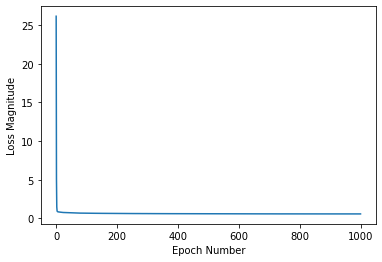

In [434]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel ('Epoch Number')
plt.ylabel ("Loss Magnitude")

plt.plot (fit_model.history ['loss'])

In [435]:
y_pred = model.predict (X_test)
y_pred

array([[0.9849777 , 0.00638613, 0.00863619],
       [0.69376385, 0.25547802, 0.05075815],
       [0.9621792 , 0.02161687, 0.01620402],
       ...,
       [0.88505155, 0.08331579, 0.0316326 ],
       [0.08156195, 0.8831993 , 0.0352388 ],
       [0.44281897, 0.49889234, 0.05828872]], dtype=float32)

In [436]:
train_acc = model.evaluate (X_train, y_train, verbose = 0)
test_acc = model.evaluate (X_test, y_test, verbose = 0)
print ("Train Loss, Accuracy : ", train_acc)
print ("Test Loss, Accuracy : ", test_acc)

Train Loss, Accuracy :  [0.5720062851905823, 0.8389416933059692]
Test Loss, Accuracy :  [0.7461812496185303, 0.7690821290016174]
